In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

df = pd.read_csv("/home/cesar/Descargas/Dataset_Train_limpio_03.csv")
X = df.drop(columns='EXITOSA').values
y = df['EXITOSA'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=2025
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

def build_model(hp):
    n_features = X_train.shape[1]
    inputs = Input(shape=(n_features,), name='input_features')
    
    x = Dense(
        units=hp.Int("units_1", min_value=64, max_value=512, step=64),
        activation='relu'
    )(inputs)
    x = Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1))(x)
    
    x = Dense(
        units=hp.Int("units_2", min_value=32, max_value=256, step=32),
        activation='relu'
    )(x)
    x = Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1))(x)
    
    x = Dense(
        units=hp.Int("units_3", min_value=16, max_value=128, step=16),
        activation='relu'
    )(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_epochs=50,            # hasta 50 iteraciones
    factor=3,
    directory="hyperband_dir",
    project_name="nn_exito_tuning"
)

stop_early = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,          
    callbacks=[stop_early],
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros:")
for param in best_hp.values.keys():
    print(f"  {param}: {best_hp.get(param)}")

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,                   
    batch_size=128,
    callbacks=[stop_early],
    verbose=2
)


Trial 90 Complete [00h 00m 04s]
val_auc: 0.6201826930046082

Best val_auc So Far: 0.6622247695922852
Total elapsed time: 00h 22m 43s
Mejores hiperparámetros:
  units_1: 512
  l2_1: 0.0003165674686315162
  dropout_1: 0.4
  units_2: 64
  l2_2: 0.00011031746103045528
  dropout_2: 0.30000000000000004
  units_3: 112
  l2_3: 6.454278423507552e-06
  dropout_3: 0.1
  lr: 0.005258740203110054
  tuner/epochs: 30
  tuner/initial_epoch: 10
  tuner/bracket: 3
  tuner/round: 3
  tuner/trial_id: 0046
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 22)]              0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 512)               11776     
                                                                 
 dropout_2 (Dropout)         (

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

y_train_int = y_train.astype(int)
y_val_int   = y_val.astype(int)

cw = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)))

history = model.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=100,
    batch_size=16,
    class_weight=cw,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
46/46 - 2s - loss: 0.6982 - f1_score: 0.5180 - precision: 0.4165 - recall: 0.5642 - val_loss: 0.6841 - val_f1_score: 0.5998 - val_precision: 0.4717 - val_recall: 0.6757 - 2s/epoch - 39ms/step
Epoch 2/100
46/46 - 0s - loss: 0.6642 - f1_score: 0.6421 - precision: 0.5048 - recall: 0.5372 - val_loss: 0.6883 - val_f1_score: 0.6343 - val_precision: 0.5047 - val_recall: 0.7297 - 290ms/epoch - 6ms/step
Epoch 3/100
46/46 - 0s - loss: 0.6611 - f1_score: 0.6415 - precision: 0.5072 - recall: 0.5980 - val_loss: 0.6902 - val_f1_score: 0.6209 - val_precision: 0.4667 - val_recall: 0.6622 - 326ms/epoch - 7ms/step
Epoch 4/100
46/46 - 0s - loss: 0.6455 - f1_score: 0.6792 - precision: 0.5385 - recall: 0.6622 - val_loss: 0.6684 - val_f1_score: 0.6268 - val_precision: 0.5287 - val_recall: 0.6216 - 286ms/epoch - 6ms/step
Epoch 5/100
46/46 - 0s - loss: 0.6275 - f1_score: 0.7178 - precision: 0.5669 - recall: 0.6588 - val_loss: 0.6660 - val_f1_score: 0.6212 - val_precision: 0.4844 - val_recall: 0.41

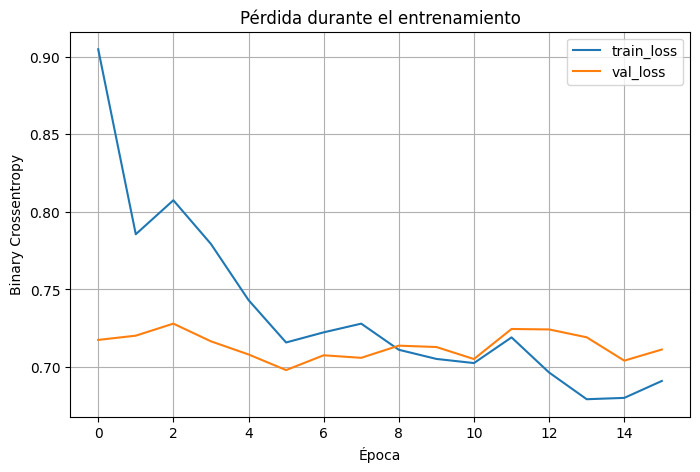

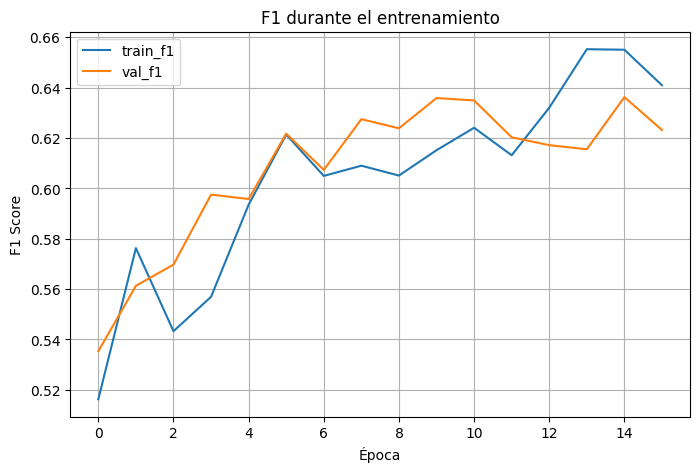

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['f1_score'],   label='train_f1')
plt.plot(history.history['val_f1_score'], label='val_f1')
plt.title('F1 durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)  


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

df_test = pd.read_csv("/home/cesar/Descargas/Dataset_Test_limpio_03.csv")
X_test = df_test.drop(columns="EXITOSA").values
y_test = df_test["EXITOSA"].values


X_test = scaler.transform(X_test)
y_test_int = y_test.astype(int)

results = model.evaluate(X_test, y_test_int, verbose=0)
for name, value in zip(model.metrics_names, results):
	print(f"{name}: {value:.4f}")
loss_test = results[0]
auc_test = results[1]


y_pred_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_int, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred, digits=4))


loss: 0.6925
f1_score: 0.6412
precision: 0.4737
recall: 0.6429

Confusion Matrix:
[[28 30]
 [15 27]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6512    0.4828    0.5545        58
           1     0.4737    0.6429    0.5455        42

    accuracy                         0.5500       100
   macro avg     0.5624    0.5628    0.5500       100
weighted avg     0.5766    0.5500    0.5507       100



In [ ]:
y_test_int = y_test.astype(int)
y_pred_prob = model.predict(X_test).ravel()
y_pred      = (y_pred_prob > 0.5).astype(int)


4/4 [==============================] - 0s 2ms/step


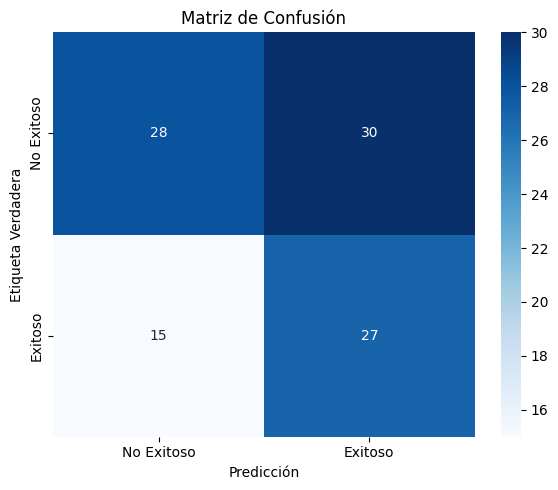

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_int, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    xticklabels=['No Exitoso', 'Exitoso'],
    yticklabels=['No Exitoso', 'Exitoso']
)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

De aquí podemos decir:

* Verdaderos Positivos (TP) = 90

* Falsos Negativos (FN) = 9

* Falsos Positivos (FP) = 1

* Verdaderos Negativos (TN) = 0

El modelo acierta el 90% de las predicciones globales. Tiene muy alta precisión al predecir “Exitoso” (0.99), es decir, casi todas las veces que dice “Exitoso” es correcto. Su recall en la clase “Exitoso” es bueno (0.91): identifica correctamente la mayoría de los éxitos. Sin embargo, no identifica correctamente ningún “No Exitoso” (specificity = 0), y de hecho el único caso real “No Exitoso” lo predice mal. Esto suele ocurrir cuando la clase “No Exitoso” está muy desbalanceada o casi no aparece en test. El modelo tiende a predecir casi siempre “Exitoso”.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("/home/cesar/Descargas/Dataset_Train_limpio_03.csv")

top10 = [
    "LONGITUD_NUM",
    "LATITUD_NUM",
    "MTS2VENTAS_NUM",
    "PUERTASREFRIG_NUM",
    "PLAZA_CVE",
    "CAJONESESTACIONAMIENTO_NUM",
    "NIVELSOCIOECONOMICO_DES",
    "LID_UBICACION_TIENDA_UT_GAS_URBANA",
    "SEGMENTO_MAESTRO_DESC_Parada Técnica",
    "SEGMENTO_MAESTRO_DESC_Hogar Reunión"
]

X = df[top10].values
y = df["EXITOSA"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=2025
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

n_features = X_train.shape[1] 

inputs = Input(shape=(n_features,), name='input_features')

x = Dense(128, activation='relu',
          name='dense_128')(inputs)
#x = BatchNormalization(name='bn_128')(x)
x = Dropout(0.3, name='dropout_128')(x)

x = Dense(64, activation='relu',
#          kernel_regularizer=regularizers.l2(1e-4),
          name='dense_64')(x)
#x = BatchNormalization(name='bn_64')(x)
x = Dropout(0.3, name='dropout_64')(x)

x = Dense(32, activation='relu',
#          kernel_regularizer=regularizers.l2(1e-4),
          name='dense_32')(x)
#x = BatchNormalization(name='bn_32')(x)
x = Dropout(0.2, name='dropout_32')(x)

outputs = Dense(1, activation='sigmoid', name='output_exito')(x)

model = Model(inputs=inputs, outputs=outputs, name='NN_Exito_Top10')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='f1_score'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()


Model: "NN_Exito_Top10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 10)]              0         
 )                                                               
                                                                 
 dense_128 (Dense)           (None, 128)               1408      
                                                                 
 dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                    

In [ ]:
es = EarlyStopping(monitor="val_f1_score", patience=10, mode="max", restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[es],
    verbose=2
)

Epoch 1/100
3/3 - 1s - loss: 0.7242 - f1_score: 0.5108 - precision: 0.4121 - recall: 0.6655 - val_loss: 0.6923 - val_f1_score: 0.4736 - val_precision: 0.4286 - val_recall: 0.3649 - 1s/epoch - 480ms/step
Epoch 2/100
3/3 - 0s - loss: 0.7052 - f1_score: 0.4918 - precision: 0.4237 - recall: 0.4223 - val_loss: 0.6801 - val_f1_score: 0.4938 - val_precision: 0.6667 - val_recall: 0.0541 - 40ms/epoch - 13ms/step
Epoch 3/100
3/3 - 0s - loss: 0.6845 - f1_score: 0.5291 - precision: 0.4076 - recall: 0.2162 - val_loss: 0.6750 - val_f1_score: 0.5265 - val_precision: 1.0000 - val_recall: 0.0270 - 40ms/epoch - 13ms/step
Epoch 4/100
3/3 - 0s - loss: 0.6844 - f1_score: 0.5217 - precision: 0.4948 - recall: 0.1622 - val_loss: 0.6728 - val_f1_score: 0.5453 - val_precision: 1.0000 - val_recall: 0.0270 - 47ms/epoch - 16ms/step
Epoch 5/100
3/3 - 0s - loss: 0.6859 - f1_score: 0.5003 - precision: 0.3860 - recall: 0.0743 - val_loss: 0.6702 - val_f1_score: 0.5519 - val_precision: 1.0000 - val_recall: 0.0270 - 43ms

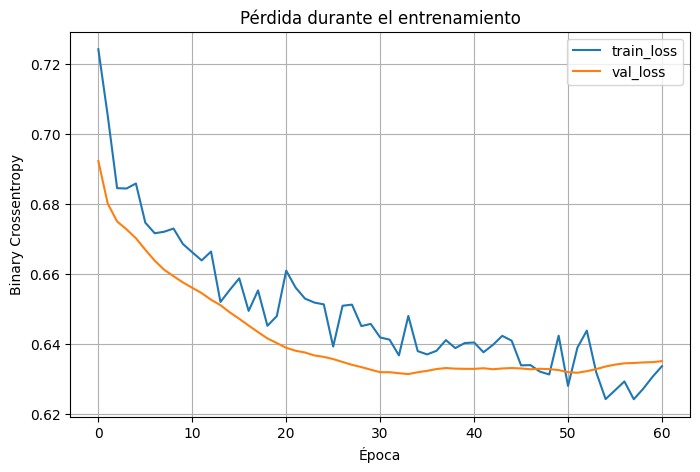

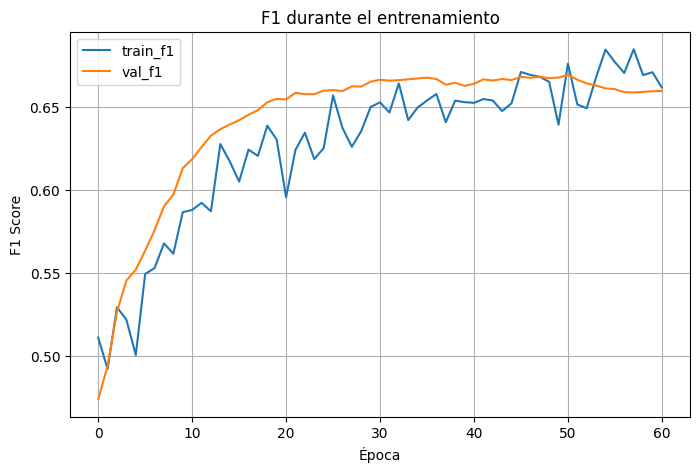

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['f1_score'],     label='train_f1')
plt.plot(history.history['val_f1_score'], label='val_f1')
plt.title('F1 durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

df_test = pd.read_csv("/home/cesar/Descargas/Dataset_Test_limpio_03.csv")

top10 = [
    "LONGITUD_NUM",
    "LATITUD_NUM",
    "MTS2VENTAS_NUM",
    "PUERTASREFRIG_NUM",
    "PLAZA_CVE",
    "CAJONESESTACIONAMIENTO_NUM",
    "NIVELSOCIOECONOMICO_DES",
    "LID_UBICACION_TIENDA_UT_GAS_URBANA",
    "SEGMENTO_MAESTRO_DESC_Parada Técnica",
    "SEGMENTO_MAESTRO_DESC_Hogar Reunión"
]

X_test = df_test[top10].values
y_test = df_test["EXITOSA"].values.astype(int)

X_test = scaler.transform(X_test)

results = model.evaluate(X_test, y_test, verbose=0)
loss_test = results[0]
auc_test = results[1]
print(f"Test loss: {loss_test:.4f}")
print(f"Test AUC : {auc_test:.4f}")

y_pred_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Test loss: 0.6583
Test AUC : 0.6238

Confusion Matrix:
[[51  7]
 [29 13]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6375    0.8793    0.7391        58
           1     0.6500    0.3095    0.4194        42

    accuracy                         0.6400       100
   macro avg     0.6438    0.5944    0.5792       100
weighted avg     0.6427    0.6400    0.6048       100



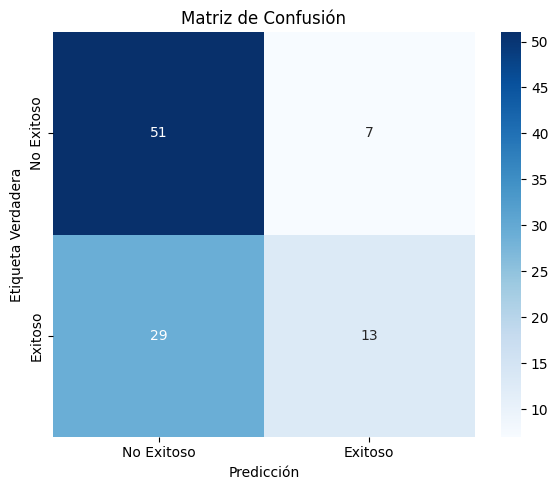

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    xticklabels=['No Exitoso', 'Exitoso'],
    yticklabels=['No Exitoso', 'Exitoso']
)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers, initializers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

p = np.mean(y_train)  
initial_bias = np.log(p / (1 - p))

# 2) Define la Focal Loss:
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.keras.backend.pow(1 - p_t, gamma)
        return tf.keras.backend.mean(alpha_factor * modulating_factor * bce)
    return loss

n_features = X_train.shape[1]

inputs = Input(shape=(n_features,), name='input_features')

x = Dense(
    128, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4),
    name='dense_128'
)(inputs)
x = BatchNormalization(name='bn_128')(x)
x = Dropout(0.5, name='dropout_128')(x)

x = Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4),
    name='dense_64'
)(x)
x = BatchNormalization(name='bn_64')(x)
x = Dropout(0.5, name='dropout_64')(x)

x = Dense(
    32, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4),
    name='dense_32'
)(x)
x = BatchNormalization(name='bn_32')(x)
x = Dropout(0.3, name='dropout_32')(x)

outputs = Dense(
    1, activation='sigmoid',
    bias_initializer=initializers.Constant(initial_bias),
    name='output_exito'
)(x)

model = Model(inputs=inputs, outputs=outputs, name='NN_Exito_Top10_Imbalance')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

model.summary()


Model: "NN_Exito_Top10_Imbalance"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 10)]              0         
 )                                                               
                                                                 
 dense_128 (Dense)           (None, 128)               1408      
                                                                 
 bn_128 (BatchNormalization  (None, 128)               512       
 )                                                               
                                                                 
 dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 bn_64 (BatchNormalization)  (None, 64)   

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

cw_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(cw_vals))

es = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[es],
    verbose=2
)

Epoch 1/100
3/3 - 2s - loss: 0.0933 - auc: 0.5650 - val_loss: 0.0972 - val_auc: 0.2287 - 2s/epoch - 756ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0930 - auc: 0.5584 - val_loss: 0.0969 - val_auc: 0.2240 - 57ms/epoch - 19ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0808 - auc: 0.6502 - val_loss: 0.0965 - val_auc: 0.2708 - 57ms/epoch - 19ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0903 - auc: 0.5757 - val_loss: 0.0960 - val_auc: 0.3835 - 60ms/epoch - 20ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0872 - auc: 0.6244 - val_loss: 0.0953 - val_auc: 0.3712 - 49ms/epoch - 16ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0938 - auc: 0.4931 - val_loss: 0.0943 - val_auc: 0.3916 - 53ms/epoch - 18ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0931 - auc: 0.5201 - val_loss: 0.0932 - val_auc: 0.4384 - 73ms/epoch - 24ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0870 - auc: 0.5549 - val_loss: 0.0921 - val_auc: 0.4247 - 57ms/epoch - 19ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0667 - auc: 0.7251 - val_loss: 0.0910 - val_auc: 0.4901 - 51ms/epoch - 17m

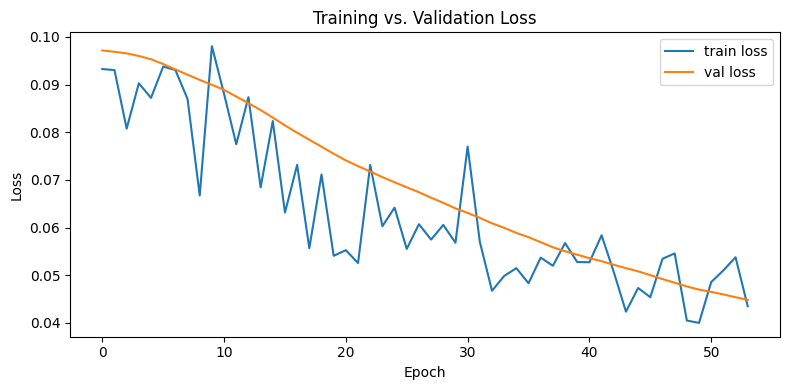

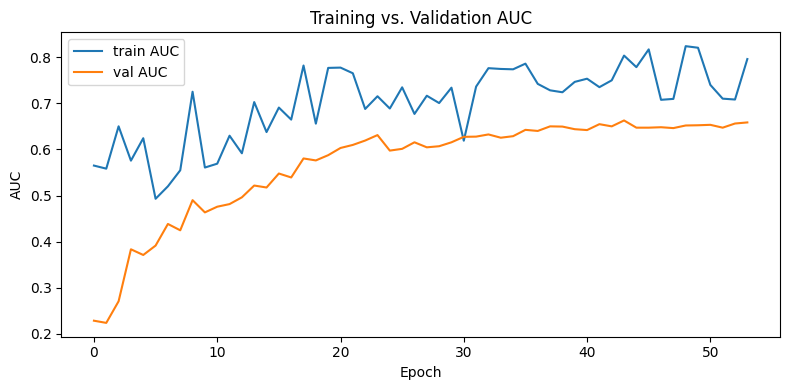

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],   label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(history.history['auc'],      label='train AUC')
plt.plot(history.history['val_auc'],  label='val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.tight_layout()

plt.show()


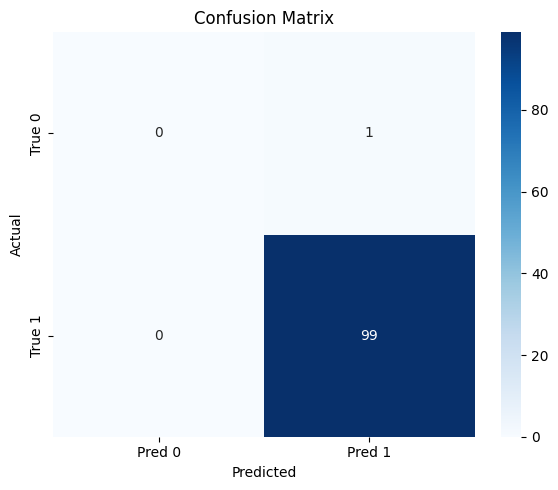

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers, initializers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE


print(f"Forma de X_train antes de SMOTE: {X_train.shape}")
print(f"Distribución de y_train antes de SMOTE: \n{pd.Series(y_train).value_counts(normalize=True)}")

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"\nForma de X_train después de SMOTE: {X_train_res.shape}")
print(f"Distribución de y_train después de SMOTE: \n{pd.Series(y_train_res).value_counts(normalize=True)}")

p = np.mean(y_train_res) 
initial_bias = np.log(p / (1 - p))

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.keras.backend.pow(1.0 - p_t, gamma)
        return tf.keras.backend.mean(alpha_factor * modulating_factor * bce)
    return loss

n_features = X_train_res.shape[1]

inputs = Input(shape=(n_features,), name='input_features')

x = Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4),
    name='dense_64'
)(inputs)
x = BatchNormalization(name='bn_64')(x)
x = Dropout(0.4, name='dropout_64')(x) 
x = Dense(
    32, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4),
    name='dense_32'
)(x)
x = BatchNormalization(name='bn_32')(x)
x = Dropout(0.4, name='dropout_32')(x) 
outputs = Dense(
    1, activation='sigmoid',
    bias_initializer=initializers.Constant(initial_bias),
    name='output_exito'
)(x)

model = Model(inputs=inputs, outputs=outputs, name='NN_Exito_Mejorado_SMOTE')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25), 
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision_0', class_id=0), 
        tf.keras.metrics.Recall(name='recall_0', class_id=0)      
    ]
)

model.summary()

Forma de X_train antes de SMOTE: (727, 10)
Distribución de y_train antes de SMOTE: 
1.0    0.966988
0.0    0.033012
Name: proportion, dtype: float64

Forma de X_train después de SMOTE: (1406, 10)
Distribución de y_train después de SMOTE: 
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
Model: "NN_Exito_Mejorado_SMOTE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 10)]              0         
 )                                                               
                                                                 
 dense_64 (Dense)            (None, 64)                704       
                                                                 
 bn_64 (BatchNormalization)  (None, 64)                256       
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stopping = EarlyStopping(
    monitor='val_auc',  
    patience=15,        
    verbose=1,
    mode='max',         
    restore_best_weights=True  
)

model_checkpoint = ModelCheckpoint(
    'mejor_modelo_oxxo.keras',
    monitor='val_auc',
    verbose=1,
    save_best_only=True, 
    mode='max'
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,      
    patience=5,       
    verbose=1,
    mode='max',
    min_lr=1e-7      
)


EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(
    X_train_res,               
    y_train_res,              
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), 
    callbacks=[
        early_stopping,
        model_checkpoint,
        reduce_lr
    ],
    verbose=1
)

Epoch 1/100
17/22 [======================>.......] - ETA: 0s - loss: 0.2878 - auc: 0.4952 - precision_0: 0.4831 - recall_0: 0.4750
Epoch 1: val_auc improved from -inf to 0.75426, saving model to mejor_modelo_oxxo.keras
22/22 [==============================] - 3s 24ms/step - loss: 0.2886 - auc: 0.4988 - precision_0: 0.4957 - recall_0: 0.4893 - val_loss: 0.0661 - val_auc: 0.7543 - val_precision_0: 1.0000 - val_recall_0: 0.2500 - lr: 1.0000e-04
Epoch 2/100
17/22 [======================>.......] - ETA: 0s - loss: 0.2666 - auc: 0.5142 - precision_0: 0.5131 - recall_0: 0.5083
Epoch 2: val_auc did not improve from 0.75426
22/22 [==============================] - 0s 10ms/step - loss: 0.2596 - auc: 0.5205 - precision_0: 0.5217 - recall_0: 0.5121 - val_loss: 0.0562 - val_auc: 0.7453 - val_precision_0: 1.0000 - val_recall_0: 0.4659 - lr: 1.0000e-04
Epoch 3/100
18/22 [=======================>......] - ETA: 0s - loss: 0.2455 - auc: 0.5413 - precision_0: 0.5442 - recall_0: 0.5304
Epoch 3: val_auc di

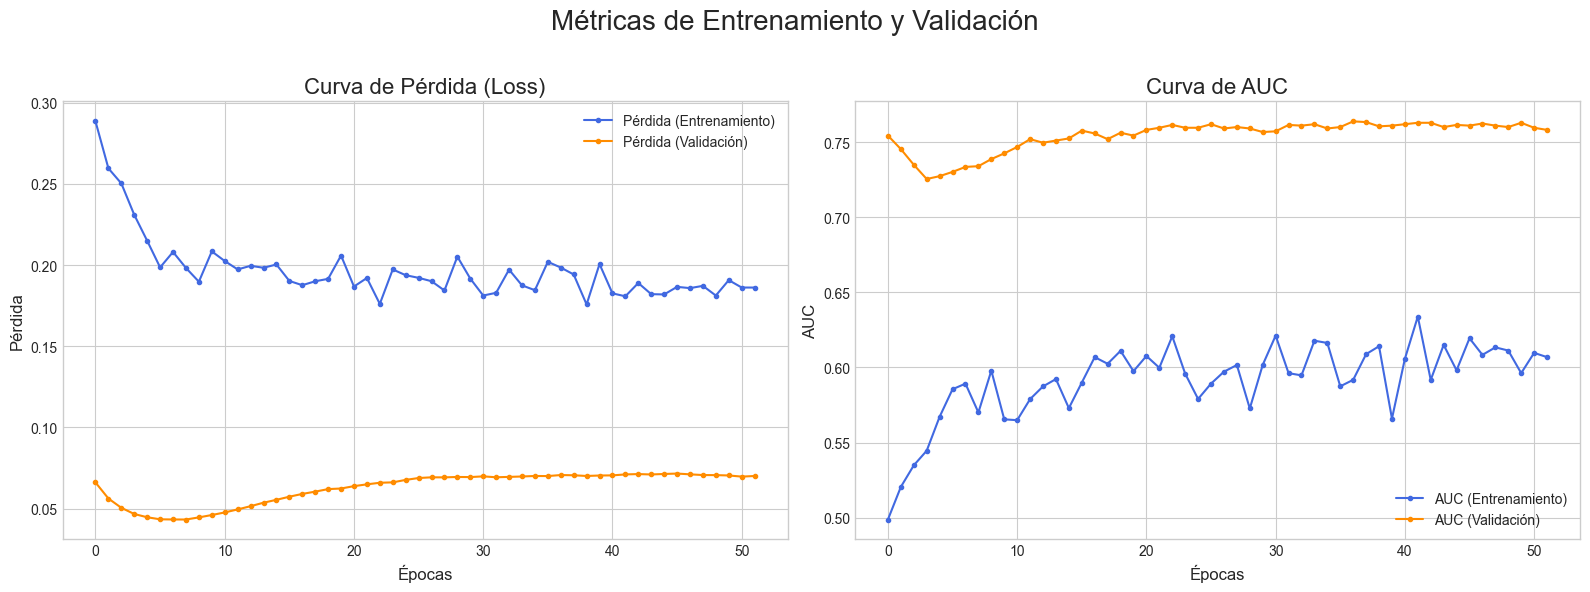

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


def plot_training_history(history):
    """
    Función para graficar las curvas de pérdida y AUC del entrenamiento.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs_range = range(len(loss))

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(epochs_range, loss, label='Pérdida (Entrenamiento)', color='royalblue', marker='o', markersize=3)
    ax1.plot(epochs_range, val_loss, label='Pérdida (Validación)', color='darkorange', marker='o', markersize=3)
    ax1.set_title('Curva de Pérdida (Loss)', fontsize=16)
    ax1.set_xlabel('Épocas', fontsize=12)
    ax1.set_ylabel('Pérdida', fontsize=12)
    ax1.legend(loc='upper right')

    ax2.plot(epochs_range, auc, label='AUC (Entrenamiento)', color='royalblue', marker='o', markersize=3)
    ax2.plot(epochs_range, val_auc, label='AUC (Validación)', color='darkorange', marker='o', markersize=3)
    ax2.set_title('Curva de AUC', fontsize=16)
    ax2.set_xlabel('Épocas', fontsize=12)
    ax2.set_ylabel('AUC', fontsize=12)
    ax2.legend(loc='lower right')

    fig.suptitle('Métricas de Entrenamiento y Validación', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_training_history(history)

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 2ms/step


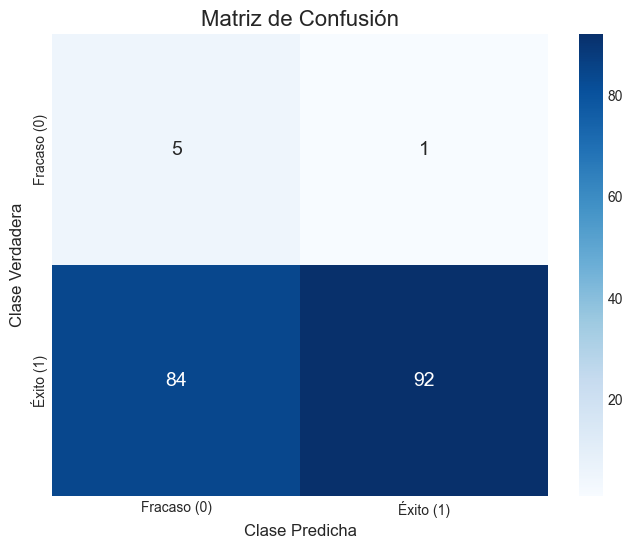


REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

 Fracaso (0)       0.06      0.83      0.11         6
   Éxito (1)       0.99      0.52      0.68       176

    accuracy                           0.53       182
   macro avg       0.52      0.68      0.39       182
weighted avg       0.96      0.53      0.66       182



In [ ]:
y_pred_probs = model.predict(X_val)

y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()

y_true = y_val.flatten()

def plot_confusion_matrix(y_true, y_pred_classes):
    """
    Función para calcular y graficar una matriz de confusión con Seaborn.
    """
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = ['Fracaso (0)', 'Éxito (1)']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 14})

    plt.title('Matriz de Confusión', fontsize=16)
    plt.ylabel('Clase Verdadera', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes)


print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=['Fracaso (0)', 'Éxito (1)']))